# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from susceptibility_scores import construct_paths_and_dataset_kwargs

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
OVERWRITE = True
ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed"]

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

In [4]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)
QUERY_IDS = list(yago_qec.keys())
QUERY_ID = QUERY_IDS[0]
SUBNAME = f"{extract_name_from_yago_uri(QUERY_ID)[0]}_{extract_name_from_yago_uri(QUERY_ID)[1]}"
QUERY_IDS[:5], len(QUERY_IDS)

(['http://schema.org/alumniOf',
  'http://schema.org/duration',
  'reverse-http://schema.org/director',
  'http://schema.org/address',
  'http://schema.org/duns'],
 56)

In [5]:
# Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
(
    data_dir,
    input_dir,
    entities_path,
    contexts_path,
    queries_path,
    val_data_path,
    model_dir,
    results_dir,
    val_results_path,
    data_id,
    model_id,
    DATASET_KWARGS_IDENTIFIABLE,
) = construct_paths_and_dataset_kwargs(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID=QUERY_ID,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    OVERWRITE=OVERWRITE,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
)

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [34]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ


In [35]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

In [8]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [9]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 0, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'OVERWRITE': True, 'ENTITY_TYPES': ['entities', 'fake_entities'], 'QUERY_TYPES': ['closed'], 'BATCH_SZ': 16, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['yago', 'analysis'], 'LOG_DATASETS': True, 'QUERY_IDS': ['http://schema.org/alumniOf', 'http://schema.org/duration', 'reverse-http://schema.org/director', 'http://schema.org/address', 'http://schema.org/duns', 'http://schema.org/founder', 'http://schema.org/elevation', 'reverse-http://schema.org/editor', 'http://schema.org/lyricist', 'http://schema.org/memberOf', 'http://schema.org/about', 'http://schema.org/gtin', 'http://schema.org/administrates', 'http://schema.org/leader', 'http://schema.org/illustrator', 'http://schema.org/material', 'http://schema.org/child

### Load Data

In [11]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path,
    index_col=0,
    converters={"contexts": literal_eval, "entity": literal_eval},
)

In [12]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2b895c323040>.


### Analyze Data

In [13]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,contexts,susceptibility_score
0,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",[Israel Zolli is an alum of McGill University ...,0.022821
1,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Q. Allan Brocka,)",[Israel Zolli is an alum of McGill University ...,0.025783
2,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(S.F. Claus,)",[Israel Zolli is an alum of McGill University ...,0.026439
3,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Morris of Aquitaine,)",[Israel Zolli is an alum of McGill University ...,0.025678
4,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Sylvester Hicks,)",[Israel Zolli is an alum of McGill University ...,0.025916


In [14]:
val_df_contexts_per_qe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q_id                  200 non-null    object 
 1   query_form            200 non-null    object 
 2   entity                200 non-null    object 
 3   contexts              200 non-null    object 
 4   susceptibility_score  200 non-null    float64
dtypes: float64(1), object(4)
memory usage: 9.4+ KB


In [15]:
val_df_contexts_per_qe["entity"].value_counts()

(Margaret Thatcher,)                           2
(Michael Martin,)                              2
(Leonard Beers,)                               2
(Conapa Penzianoti,)                           2
(Carles Magraner,)                             2
                                              ..
(John S. Traill,)                              2
(Campbell,)                                    2
(List of members of the Battle of Alameda,)    2
(Dougal Dixon,)                                2
(Jason Koon,)                                  2
Name: entity, Length: 100, dtype: int64

In [16]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Israel Zolli is an alum of McGill University Faculty of Law.\n',
 "Denny O'Brien is an alum of Uppsala University.\n",
 'Peter McLaughlin is an alum of University of Toronto.\n',
 'Jay Brira is an alum of Yale Law School.\n',
 'Conapa Penzianoti is an alum of Johns Hopkins Bloomberg School of Public Health.\n',
 'Carl Georg With is an alum of University of Minnesota Law School.\n',
 'John Passmore is an alum of Niles West High School.\n',
 'Campbell is an alum of Université de Moncton.\n',
 'Jason Koon is an alum of LaGrange High School.\n',
 'Vitti Meriter is an alum of University of New Mexico.\n']

In [17]:
# import re

# p = r"of\s(.*?)(?=\sis\b)"
# c_ents = [
#     re.search(p, text).group(1) for text in val_df_contexts_per_qe.iloc[0]["contexts"]
# ]
# ents = val_df_contexts_per_qe["entity"].tolist()
# if (
#     DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
#     and len(set(c_ents).intersection(set(ents))) != 0
# ):
#     raise ValueError(
#         "ablate_out_relevant_contexts is True, but the contexts contain entities in the entities list."
#     )

In [18]:
entities_df = pd.DataFrame(
    {k: v for k, v in yago_qec[QUERY_ID].items() if k in {"entities", "fake_entities"}}
)
real_ents = set(entities_df["entities"])
fake_ents = set(entities_df["fake_entities"])
print("# unique real ents:", len(real_ents))
print("# unique fake ents:", len(fake_ents))
print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
print("Overlapping ents:", real_ents.intersection(fake_ents))
entities_df["entities"].value_counts(), entities_df["fake_entities"].value_counts()

# unique real ents: 999
# unique fake ents: 984
# overlapping ents: 0
Overlapping ents: set()


(Jonathan Powell       2
 Phil Fortunato        1
 Georgios Roilos       1
 Zeno Payne Metcalf    1
 Chris Heaphy          1
                      ..
 Barton Lynch          1
 Lee Young-jin         1
 Paul Girolami         1
 Charles Oxenden       1
 Charles Moseley       1
 Name: entities, Length: 999, dtype: int64,
 Adam and Eve                                         4
 Abraham                                              3
 Margaret Thatcher                                    3
 Adolf Hitler                                         3
 Bobby Bobby                                          2
                                                     ..
 Melchert Baywell                                     1
 Andrey Tharpe                                        1
 Walter Clayford, 1st Viscount Clayford of Angfall    1
 Inau Hill                                            1
 Robert Bruce                                         1
 Name: fake_entities, Length: 984, dtype: int64)

In [19]:
entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
print(entities_df_tidy.head())
entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
entities_df_tidy.head()
entities_df_tidy.info()

       type           entity
0  entities   Phil Fortunato
1  entities   Tuomas Knowles
2  entities     David Rimoin
3  entities  Bruce Dalrymple
4  entities  Zach Charbonnet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    2000 non-null   object
 1   entity  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [20]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    entities_df_tidy,
    left_on="entity",
    right_on="entity",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "susceptibility_score",
    ]
]
val_df_per_qe

,q_id,query_form,entity,type,susceptibility_score
0,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",fake_entities,0.022821
1,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",fake_entities,0.022821
2,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Margaret Thatcher,)",fake_entities,0.022821
3,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Q. Allan Brocka,)",entities,0.025783
4,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(S.F. Claus,)",fake_entities,0.026439
...,...,...,...,...,...
199,http://schema.org/alumniOf,Q: Does {answer} count {entity} as one of its ...,"(Georges de Luna,)",fake_entities,0.027045
200,http://schema.org/alumniOf,Q: Does {answer} count {entity} as one of its ...,"(C. O'Conor Goolrick,)",entities,0.024820
201,http://schema.org/alumniOf,Q: Does {answer} count {entity} as one of its ...,"(Permanata,)",fake_entities,0.027311
202,http://schema.org/alumniOf,Q: Does {answer} count {entity} as one of its ...,"(Dr. Dre,)",fake_entities,0.018595


In [21]:
query_forms = val_df_per_qe["query_form"].unique()
query_forms

array(['Q: Is {entity} an alum of {answer}?\nA:',
       'Q: Does {answer} count {entity} as one of its alumni?\nA:'],
      dtype=object)

In [22]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
    by="susceptibility_score"
)

,q_id,query_form,entity,type,susceptibility_score
22,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Theodor Waller Kaller,)",fake_entities,0.020138
77,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Elizabeth I of England,)",fake_entities,0.020886
70,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Bernie Brillstein,)",entities,0.021470
29,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Dougal Dixon,)",entities,0.022562
95,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Hermione Lee,)",entities,0.022595
...,...,...,...,...,...
10,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Baton, Davis,)",fake_entities,0.039718
35,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Lf. Clowney,)",fake_entities,0.040363
31,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Campbell,)",fake_entities,0.040598
91,http://schema.org/alumniOf,Q: Is {entity} an alum of {answer}?\nA:,"(Carl Georg With,)",entities,0.046923


In [23]:
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]][
    ["entity", "type", "susceptibility_score"]
].sort_values(by="susceptibility_score")

,entity,type,susceptibility_score
22,"(Theodor Waller Kaller,)",fake_entities,0.020138
77,"(Elizabeth I of England,)",fake_entities,0.020886
70,"(Bernie Brillstein,)",entities,0.021470
29,"(Dougal Dixon,)",entities,0.022562
95,"(Hermione Lee,)",entities,0.022595
...,...,...,...
10,"(Baton, Davis,)",fake_entities,0.039718
35,"(Lf. Clowney,)",fake_entities,0.040363
31,"(Campbell,)",fake_entities,0.040598
91,"(Carl Georg With,)",entities,0.046923


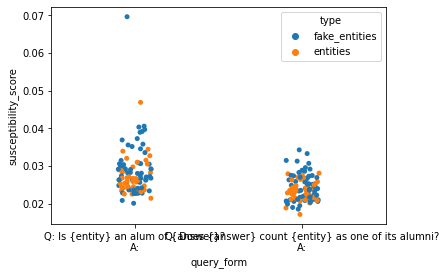

In [24]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = f"plot_susscore_vs_queryform_real_fake_{SUBNAME}"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [25]:
def construct_df_given_query_id(query_id: List[str], verbose=True):
    # Construct paths from run parameters and construct DATASET_KWARGS_IDENTIFIABLE
    (
        data_dir,
        input_dir,
        entities_path,
        contexts_path,
        queries_path,
        val_data_path,
        model_dir,
        results_dir,
        val_results_path,
        data_id,
        model_id,
        DATASET_KWARGS_IDENTIFIABLE,
    ) = construct_paths_and_dataset_kwargs(
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        OVERWRITE=OVERWRITE,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
    )
    # Analysis dir
    analysis_dir = os.path.join(data_dir, "analysis")
    if verbose:
        print(f"Analysis dir: {analysis_dir}")
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)

    # Set random seeds
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    from ast import literal_eval

    try:
        val_df_contexts_per_qe = pd.read_csv(
            val_results_path,
            index_col=0,
            converters={"contexts": literal_eval, "entity": literal_eval},
        )
    except FileNotFoundError as e:
        print(f"Unable to find file at {val_results_path}, full error: {e}")
        return None
    if verbose:
        print("val_df_contexts_per_qe info:")
        print(val_df_contexts_per_qe.info())
        print(val_df_contexts_per_qe["entity"].value_counts())
        print(val_df_contexts_per_qe.iloc[0]["contexts"][:10])
        print("Entities info:")
    entities_df = pd.DataFrame(
        {
            k: v
            for k, v in yago_qec[query_id].items()
            if k in {"entities", "fake_entities"}
        }
    )
    real_ents = set(entities_df["entities"])
    fake_ents = set(entities_df["fake_entities"])

    entities_df_tidy = entities_df.melt(var_name="type", value_name="entity")
    entities_df_tidy["entity"] = entities_df_tidy["entity"].apply(lambda x: (x,))
    if verbose:
        print("# unique real ents:", len(real_ents))
        print("# unique fake ents:", len(fake_ents))
        print("# overlapping ents:", len(real_ents.intersection(fake_ents)))
        print("Overlapping ents:", real_ents.intersection(fake_ents))
        print(
            entities_df["entities"].value_counts(),
            entities_df["fake_entities"].value_counts(),
        )
        print(entities_df_tidy.head())
        print(entities_df_tidy.info())

    val_df_per_qe = val_df_contexts_per_qe.merge(
        entities_df_tidy,
        left_on="entity",
        right_on="entity",
        how="left",
    )[
        [
            "q_id",
            "query_form",
            "entity",
            "type",
            "susceptibility_score",
        ]
    ]
    query_forms = val_df_per_qe["query_form"].unique()

    if verbose:
        print("val_df_per_qe info:")
        print(val_df_per_qe)

        print(f"query forms: {query_forms}")
        print(
            "Sorted sus scores:",
            val_df_per_qe[val_df_per_qe["query_form"] == query_forms[0]].sort_values(
                by="susceptibility_score"
            ),
        )

    return val_df_per_qe

In [26]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(query_id, verbose=False)
    for query_id in QUERY_IDS
}

Data dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed/0
Model dir: data/YagoECQ/schema_alumniOf/schema_alumniOf-mc500-me100-ET_entities_fake_entities-QT_closed/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-ET_entities_fake_entities-QT_closed/0
Model dir: data/YagoECQ/schema_duration/schema_duration-mc500-me100-ET_entities_fake_entities-QT_closed/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-ET_entities_fake_entities-QT_closed/0
Model dir: data/YagoECQ/reverse-schema_director/reverse-schema_director-mc500-me100-ET_entities_fake_entities-QT_closed/0/models/EleutherAI/pythia-6.9b-deduped-8bit
Data dir: data/YagoECQ/schema_address/schema_address-mc500-me100-ET_entities_fake_entities-QT_closed/0
Model dir: data/YagoECQ/schema_address/schema_address-mc500-me100-ET_entities_fake_entities-QT_closed/0

In [27]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/gtin', 'http://schema.org/motto', 'http://schema.org/founder'}


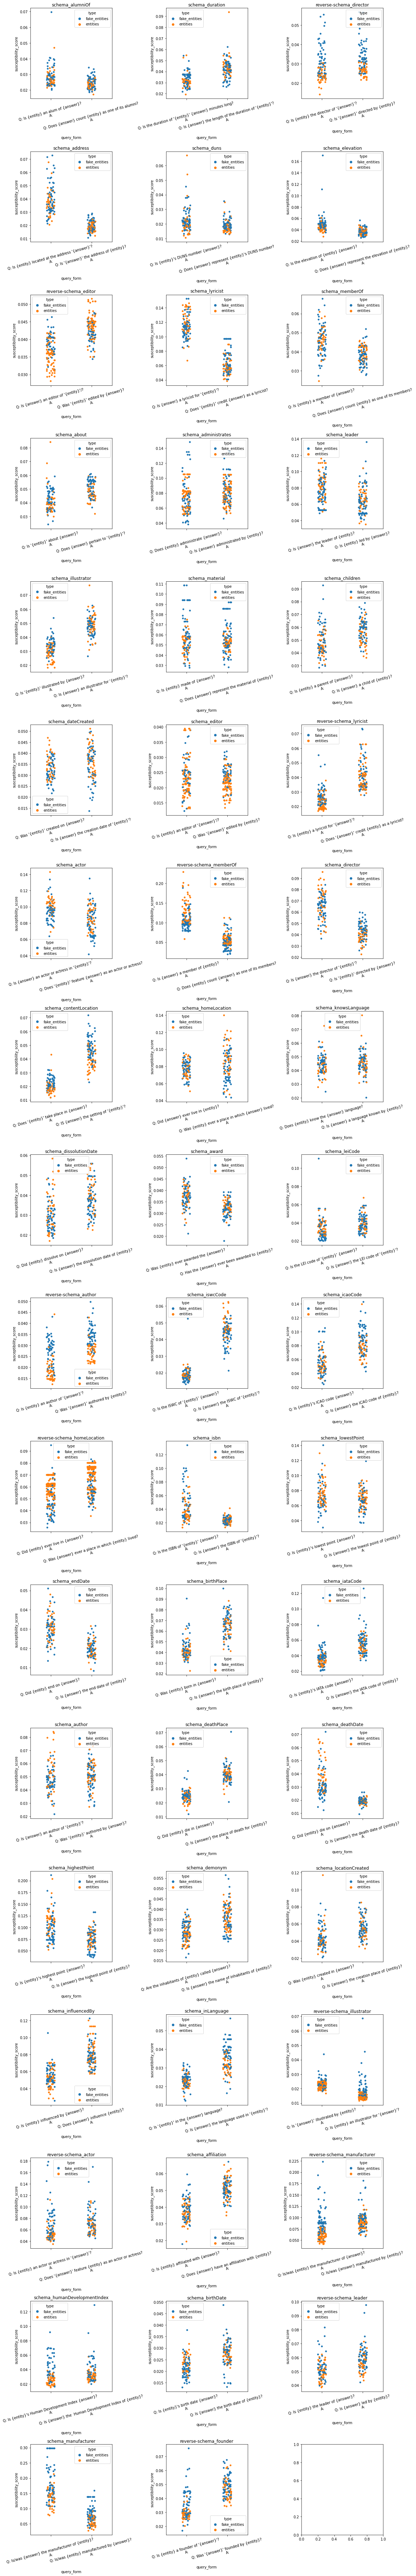

In [36]:
import math
b
num_plots = len(qid_to_val_df_per_qe)
num_cols = 3
num_rows = math.ceil(num_plots // 3) + 1
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(16, 100))

count = 0
for qid, df in qid_to_val_df_per_qe.items():
    row = math.ceil(count // num_cols)
    col = count % num_cols
    ax = axes[row][col]
    sns.stripplot(
        data=df,
        x="query_form",
        y="susceptibility_score",
        hue="type",
        ax=ax,
        # hue="is_real",
        # dodge=True
        # jitter=0.1,
        # legend="full",
    )
    subname = (
        f"{extract_name_from_yago_uri(qid)[0]}_{extract_name_from_yago_uri(qid)[1]}"
    )
    ax.set_title(subname)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
    count += 1
plt.tight_layout()
plot_name = f"plot_susscore_vs_queryform_real_fake_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [58]:
from scipy.stats import ttest_ind


def ttest(df):
    sus_scores_real = df[df["type"] == "entities"]["susceptibility_score"]
    sus_scores_fake = df[df["type"] == "fake_entities"]["susceptibility_score"]
    return ttest_ind(sus_scores_real, sus_scores_fake, alternative="less").pvalue


ttest_scores = {k: ttest(v) for k, v in qid_to_val_df_per_qe.items()}
pd.DataFrame(
    dict(sorted(ttest_scores.items(), key=lambda item: item[1])).items(),
    columns=["query", "p-value"],
)
# ttest_scores =
# ttest(qid_to_val_df_per_qe["http://schema.org/alumniOf"])
# ttest(next(iter(qid_to_val_df_per_qe))[1])
# for qid, df in qid_to_val_df_per_qe.items():

,query,p-value
0,reverse-http://schema.org/manufacturer,3.367240e-18
1,reverse-http://schema.org/director,1.163236e-17
2,reverse-http://schema.org/author,1.859091e-17
3,reverse-http://schema.org/illustrator,3.440917e-13
4,http://schema.org/humanDevelopmentIndex,5.916233e-12
5,http://schema.org/manufacturer,2.247180e-06
6,reverse-http://schema.org/actor,1.481546e-05
7,http://schema.org/material,1.535454e-05
8,reverse-http://schema.org/founder,1.216422e-04
9,reverse-http://schema.org/leader,2.897454e-04


### Examining model outputs

In [59]:
from measuring.estimate_probs import (
    # estimate_prob_y_given_context_and_entity,
    # estimate_prob_x_given_e,
    # estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    get_prob_next_word,
    #     score_model_for_next_word_prob,
    #     create_position_ids_from_input_ids,
    #     sharded_score_model,
    #     estimate_entity_score,
    #     kl_div,
    #     difference,
    #     difference_p_good_only,
    #     difference_abs_val,
)
from preprocessing.utils import format_query
import pprint

In [ ]:
try:
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    print(f"Failed to load model {MODEL_ID} in 8-bit. Attempting to load normally.")
    model = GPTNeoXForCausalLM.from_pretrained(
        MODEL_ID,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)

In [ ]:
val_df_contexts_per_qe.sort_values(by="susceptibility_score").iloc[0]

In [25]:
def print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50):
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=context),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=k,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

In [25]:
query_forms = val_df_per_qe["query_form"].unique()
val_df_contexts_per_qe[
    val_df_contexts_per_qe["query_form"] == query_forms[1]
].sort_values(by="susceptibility_score")

,q_id,query_form,entity,contexts,susceptibility_score
94,capital_of,The capital of {} is,"(Nagorno-Karabakh Republic,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.015117
103,capital_of,The capital of {} is,"(Republic of China (Taiwan),)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.027095
91,capital_of,The capital of {} is,"(Paraguay,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.035673
107,capital_of,The capital of {} is,"(Kyrgyzstan,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.048575
101,capital_of,The capital of {} is,"(Somalia,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.062413
...,...,...,...,...,...
141,capital_of,The capital of {} is,"(Consuleo,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.751852
136,capital_of,The capital of {} is,"(Wula,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.760516
148,capital_of,The capital of {} is,"(Fictional Country,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.796028
120,capital_of,The capital of {} is,"(Cadasa,)","[The capital of Royal Hungary is Riyadh.\n, Th...",0.831525


In [64]:
pp = pprint.PrettyPrinter()
row = (
    val_df_contexts_per_qe[val_df_contexts_per_qe["query_form"] == query_forms[1]]
    .sort_values(by="susceptibility_score")
    .iloc[0]
)
entity = row["entity"]
contexts = row["contexts"][430:440]
query = row["query_form"]
print(f"***Investigating the following query for entity {entity}:***")
print(format_query(query=query, entity=entity, context=""))
print("CMI:", estimate_cmi(query, entity, contexts, model, tokenizer))

print("***Top-k next token probs WITHOUT any context:***")
print_top_k_next_token_probs(model, tokenizer, query, entity, context="", k=50)
print("\n\n")
for context in contexts[:5]:
    print(f"*{format_query(query=query, entity=entity, context=context)}*")
    print_top_k_next_token_probs(model, tokenizer, query, entity, context, k=50)
    print("\n\n")


print("***Sampled next 5 generated tokens WITHOUT any context:***")
tokens = tokenizer(
    format_query(query=query, entity=entity, context=""),
    padding=True,
    return_tensors="pt",
).to(model.device)
print(f"Prompt length:{len(tokens['input_ids'][0])}")
samples = model.generate(
    **tokens,
    num_return_sequences=10,
    do_sample=True,
    max_length=len(tokens["input_ids"][0]) + 5,
)
pp.pprint(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

***Investigating the following query for entity ('Nagorno-Karabakh Republic',):***
The capital of Nagorno-Karabakh Republic is
CMI: 0.017251218948326867
***Top-k next token probs WITHOUT any context:***


/scratch/tmp.41099897.kevidu/ipykernel_27225/2345229264.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.898, 'ĠSte', 2951), (0.0291, 'ĠY', 714), (0.01984, 'Ġthe', 253), (0.01865, 'ĠB', 378), (0.005775, 'ĠT', 308), (0.00436, 'Ġa', 247), (0.002972, 'Ġoccupied', 13598), (0.002262, 'Ġalso', 671), (0.001789, 'Ċ', 187), (0.001747, 'ĠSh', 1608), (0.000935, 'Ġits', 697), (0.000832, 'Ġcapital', 5347), (0.000769, 'Ġcurrently', 4390), (0.0007343, 'Ġnot', 417), (0.000717, 'ĠM', 353), (0.000706, 'ĠN', 427), (0.000576, 'ĠArts', 15118), (0.0005083, 'Ġin', 275), (0.0004778, 'ĠNK', 18156), (0.0004704, 'ĠGy', 20925), (0.000463, 'Ġconsidered', 2783), (0.0004385, 'Ġan', 271), (0.0004249, 'Ġcity', 2846), (0.0004249, 'Ġlocated', 4441), (0.0004022, 'Ġnamed', 4907), (0.000396, 'ĠS', 322), (0.000396, 'Ġrepublic', 23822), (0.0003662, 'Ġwithin', 1561), (0.0003579, ',', 13), (0.0003467, 'Ġ"', 346), (0.0003335, 'ĠE', 444), (0.0003037, 'ĠA', 329), (0.0002897, ':', 27), (0.0002897, 'Ġcalled', 1925), (0.0002875, 'ĠAl', 1219), (0.0002556, 'ĠEl', 3599), (0.0002365, 'ĠArt', 3975), (0.000231, 'ĠAst', 15123), (0.0002292

### Correlation with Pile frequency

In [26]:
unigram_frequencies = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-unigrams.bin",
    dtype=np.int64,
    mode="r",
    shape=(50277,),
)
view = np.memmap(
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia_pile_idxmaps/pile_0.87_deduped_text_document.bin",
    dtype=np.uint16,
    mode="r",
)

In [34]:
import zstandard as zstd
import pickle
from scipy.sparse import load_npz

file_path = (
    "/cluster/work/cotterell/shared_datasets/pile_deduped/pythia-deduped-bigrams.zst"
)
# # Open the zstd file for reading in binary mode
# with open(file_path, 'rb') as compressed_file:
#     dctx = zstd.ZstdDecompressor()
#     with dctx.stream_reader(compressed_file) as reader:
#         # Decompress the zstd file and load the pickled data
#         pickled_data = pickle.loads(reader.read())

# Reconstruct the SciPy sparse array
# sparse_array = load_npz(pickled_data)

with open(file_path, "rb") as f:
    data = f.read()

dctx = zstd.ZstdDecompressor()
decompressed = dctx.decompress(data)
pickled_scipy = pickle.loads(decompressed)

AttributeError: Can't get attribute 'csr_array' on <module 'scipy.sparse._csr' from '/cluster/home/kevidu/.local/lib/python3.10/site-packages/scipy/sparse/_csr.py'>

In [ ]:
len(decompressed), type(decompressed), decompressed[:5]

In [25]:
entities = val_df_contexts_per_qe["entity"].apply(lambda x: x[0]).unique().tolist()

In [26]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",
)
tokenized_entities = [tuple(e) for e in tokenizer(entities)["input_ids"]]
tokenized_entities_prespace = [
    tuple(e) for e in tokenizer([" " + e for e in entities])["input_ids"]
]
tokenized_entities
tokenized_entities_prespace
entities_to_freqs = {
    e: {tokenized_entities[i]: 0, tokenized_entities_prespace[i]: 0}
    for i, e in enumerate(entities)
}
entities_to_freqs["Zimbabwe"]

# tokenized_entities
# {
#     entity:
#         {
#             tokens_without_space: count,
#             tokens_with_space: count
#         }
# }

{(59, 35976): 0, (38581,): 0}

In [43]:
# relevant_token_seqs = set(tokenized_entities + tokenized_entities_prespace)
relevant_token_seqs = set(tokenized_entities_prespace)
relevant_token_seqs

{(330, 15333, 66),
 (353, 636, 263),
 (367, 12043, 11491),
 (380, 47708, 6056),
 (399, 29420, 273, 41813),
 (401, 15835, 17241),
 (411, 3627),
 (416, 321, 10157, 571),
 (416, 1595, 266, 255, 723, 66),
 (416, 11318),
 (418, 408, 532, 307),
 (427, 351, 6736),
 (427, 1596, 571),
 (443, 5945),
 (444, 1274, 66),
 (473, 33205, 5741),
 (500, 1441, 316),
 (611, 6147, 4233, 91, 18549),
 (611, 16208, 552, 1758),
 (659, 1377, 91, 518),
 (1023, 445, 262, 8125),
 (1457, 2263, 264, 9409),
 (1457, 40868, 90),
 (1780, 21720, 261),
 (1986, 11491, 11442, 11011),
 (2263, 261, 5503),
 (2903, 90, 5182),
 (2956, 19438, 333),
 (3083, 11825),
 (3189, 2131),
 (3512, 19257),
 (3532, 251, 4412),
 (3660, 38148),
 (4031, 4448, 301, 34526),
 (4135,),
 (4563, 1657, 80),
 (4687, 273, 329, 719),
 (4687, 273, 4135, 313, 53, 2284, 10320, 10),
 (4687, 273, 7511, 18442),
 (4782, 8170, 7531, 8694, 1870, 366),
 (4952, 8125),
 (5003, 50190),
 (5769, 25183),
 (6176,),
 (6984, 2320),
 (7949, 5410, 66),
 (8229, 15354),
 (8502,)

In [44]:
from collections import Counter

unigram_tokens = {
    t: unigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 1
}
unigram_tokens

{(44637,): 250587,
 (25270,): 548240,
 (46699,): 224094,
 (16842,): 1059489,
 (31683,): 431605,
 (17358,): 1093472,
 (45914,): 226142,
 (4135,): 8029900,
 (20341,): 729429,
 (38581,): 301247,
 (6176,): 4613886,
 (8502,): 1698202}

In [ ]:
bigram_tokens = {
    t: bigram_frequencies[t[0]] for t in relevant_token_seqs if len(t) == 2
}

In [45]:
for e, freq_dicts in entities_to_freqs.items():
    total = 0
    for token_seqs in freq_dicts.keys():
        if len(token_seqs) == 1:
            freq_dicts[token_seqs] = unigram_frequencies[token_seqs[0]]
        if len(token_seqs) == 2:
            freq_dicts[token_seqs] = bigram_frequencies[token_seqs]
        total += freq_dicts[token_seqs]
    freq_dicts["total"] = total

38581 301247
25270 548240
22800 749642
4135 8029900
45914 226142
16842 1059489
46699 224094
37796 329569
6176 4613886
20341 729429
44637 250587
24900 626526
8502 1698202
45901 135822
31683 431605
39312 289723
17358 1093472


In [46]:
entities_to_freqs

{'Zimbabwe': {(59, 35976): 0, (38581,): 301247, 'total': 903741},
 'Paraguay': {(4221, 19438, 333): 0, (2956, 19438, 333): 0, 'total': 0},
 'Finland': {(17398, 1373): 0, (25270,): 548240, 'total': 1644720},
 'New Caledonia': {(4257, 2263, 264, 9409): 0,
  (1457, 2263, 264, 9409): 0,
  'total': 0},
 'Nagorno-Karabakh Republic': {(47,
   356,
   41530,
   14,
   40016,
   357,
   18980,
   4687): 0,
  (21987, 41530, 14, 40016, 357, 18980, 4687): 0,
  'total': 0},
 'Faroe Islands': {(24234, 3703, 18708): 0,
  (10351, 3703, 18708): 0,
  'total': 0},
 'China': {(22800,): 749642, (4135,): 8029900, 'total': 26338626},
 'United Kingdom Northern Ireland': {(11586, 11491, 11442, 11011): 0,
  (1986, 11491, 11442, 11011): 0,
  'total': 0},
 'Tanzania': {(53, 11670, 16642): 0, (45914,): 226142, 'total': 678426},
 'Sweden': {(42589, 257): 0, (16842,): 1059489, 'total': 3178467},
 'Honduras': {(41, 857, 27356): 0, (44509, 27356): 0, 'total': 0},
 'Somalia': {(52, 7838, 571): 0, (46699,): 224094, 'tot

In [68]:
entity_counts = dict(
    sorted(
        {
            (k,): v["total"] for k, v in entities_to_freqs.items() if v["total"] != 0
        }.items(),
        key=lambda x: x[1],
    )
)
ent_freq_df = pd.DataFrame(
    list(entity_counts.items()), columns=["entity", "ent_frequency"]
)
ent_freq_df

In [81]:
val_df_per_qe_with_freq = val_df_per_qe.merge(ent_freq_df)
val_df_per_qe_with_freq["log_ent_frequency"] = val_df_per_qe_with_freq[
    "ent_frequency"
].apply(np.log)
val_df_per_qe_with_freq

,q_id,query_form,entity,type,is_real,susceptibility_score,ent_frequency,log_ent_frequency
0,capital_of,Q: What is the capital of {}?\nA:,"(Zimbabwe,)",countryCapital,True,0.055717,903741,13.714298
1,capital_of,The capital of {} is,"(Zimbabwe,)",countryCapital,True,0.083346,903741,13.714298
2,capital_of,Q: What is the capital of {}?\nA:,"(Finland,)",countryCapital,True,0.038184,1644720,14.313081
3,capital_of,The capital of {} is,"(Finland,)",countryCapital,True,0.070862,1644720,14.313081
4,capital_of,Q: What is the capital of {}?\nA:,"(China,)",countryCapital,True,0.074832,26338626,17.086547
5,capital_of,The capital of {} is,"(China,)",countryCapital,True,0.248528,26338626,17.086547
6,capital_of,Q: What is the capital of {}?\nA:,"(Tanzania,)",countryCapital,True,0.072143,678426,13.427531
7,capital_of,The capital of {} is,"(Tanzania,)",countryCapital,True,0.086598,678426,13.427531
8,capital_of,Q: What is the capital of {}?\nA:,"(Sweden,)",countryCapital,True,0.039669,3178467,14.971910
9,capital_of,The capital of {} is,"(Sweden,)",countryCapital,True,0.066374,3178467,14.971910


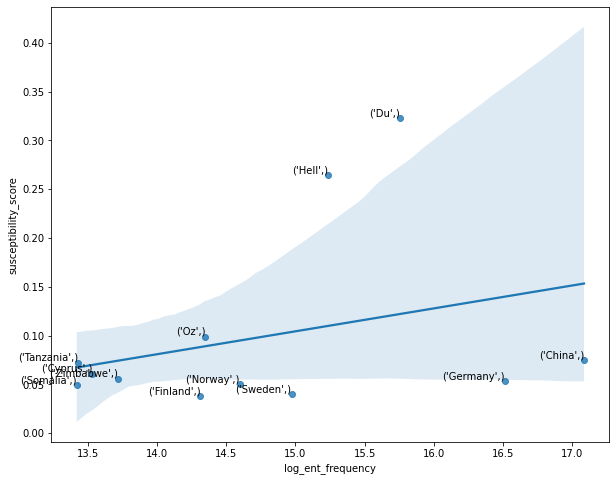

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
df = val_df_per_qe_with_freq[val_df_per_qe_with_freq["query_form"] == query_forms[0]]
plot = sns.regplot(
    data=df,
    x="log_ent_frequency",
    y="susceptibility_score",
    # logx=True,
    # hue="query_form",
    ax=ax,
    label=True,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

for i, row in df.iterrows():
    ax.text(
        row["log_ent_frequency"],
        row["susceptibility_score"],
        row["entity"],
        ha="right",
        va="bottom",
    )

plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic_ent_frequency"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# 24000 min = 2+ weeks of CPU hours to finish lmao
from tqdm.auto import trange
CHUNK_SIZE = 50_000_000
VOCAB_SIZE = 50_277
window_size = 1
for i in trange(0, len(view), CHUNK_SIZE):
    chunk = view[i : i + CHUNK_SIZE]
    for j in trange(len(chunk) - (window_size - 1)):
        ngram = tuple(chunk[j: j+window_size])
        if ngram in unigram_tokens:
            unigram_tokens[ngram] += 1        
    # counts += np.bincount(chunk, minlength=len(counts))

  0%|          | 0/4144 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

  0%|          | 0/50000000 [00:00<?, ?it/s]

In [ ]:
unigram_frequencies

In [31]:
tokenizer.convert_ids_to_tokens([38581])

['ĠZimbabwe']

In [ ]:
wandb.finish()